# ROC (all delay)

In [1]:
from linares_plot import *
import scipy.io as io
import pickle
from scipy.ndimage import gaussian_filter
from scipy import misc
import os
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


In [2]:
def circ_dist(a1,a2):
    ## Returns the minimal distance in angles between to angles 
    op1=abs(a2-a1)
    angs=[a1,a2]
    op2=min(angs)+(360-max(angs))
    options=[op1,op2]
    return min(options)

In [3]:
path_ = 'C:\\Users\\David\\Desktop\\IDIBAPS\\brian_simulations\\r8'
all_= os.listdir(path_)

In [4]:
print(len(all_))

257


In [5]:
data = io.loadmat(path_ + '\\' + all_[0]) #,{'rate':rates, 'spktm': spikes.it})
print(len(data['ratedelay'][0]) )
print(data['IEext'][0][0])
print(data['pos_stim'][0][0])

16000
0
0.0


In [6]:
rates_=[]
pos_stim = []
Iexts=[]

for sim_ in range(len(all_)): #len(all_)
    simx = io.loadmat(path_ + '\\' + all_[sim_])
    rates_.append(simx['ratedelay'][0])
    pos_stim.append(360*simx['pos_stim'][0][0])
    Iexts.append(simx['IEext'][0][0])



Rates = np.array(rates_)
IExts = np.array(Iexts) 
Positions=np.array(pos_stim)

In [7]:
np.shape(Rates)

(257, 16000)

In [8]:
Rates

array([[ 1.  ,  0.  ,  4.25, ..., 13.25,  0.  ,  0.  ],
       [ 1.25,  0.  ,  4.75, ..., 11.75,  0.  ,  0.  ],
       [ 1.5 ,  0.  ,  5.  , ..., 12.75,  0.  ,  0.  ],
       ...,
       [ 6.  ,  0.  , 16.25, ..., 21.75,  0.25,  0.75],
       [ 6.5 ,  0.  , 17.5 , ..., 20.  ,  0.5 ,  0.75],
       [ 7.25,  0.25, 17.25, ..., 21.  ,  1.  ,  0.75]])

In [9]:
np.unique(IExts)

array([0. , 0.5])

### Loop to calculate ROC


In [40]:
Neurons_  = np.arange(0,16000,100)
#Neurons_  = np.arange(0,16000,1) ##do not take all, just 10% of them

In [41]:
45/8

5.625

In [48]:
dfx['position'].iloc[index_max_rate]

316.8

In [49]:
dfx['rate']

0      0.00
1      0.25
2      0.00
3      0.25
4      0.00
       ... 
120    0.25
121    0.75
122    0.75
123    0.75
124    0.75
Name: rate, Length: 125, dtype: float64

In [55]:
Iext_off = 0
Iext_on = 0.5

lim_RF = 45 ##limit to consider a position is inside the RF of the neuron
base_fpr = np.linspace(0, 1, 101)


number_neurons=len(Neurons_)

auc_off = np.zeros(number_neurons)
auc_on = np.zeros(number_neurons)

tprs_on = []
tprs_off = []


for idx_neuron, Neuron in enumerate(Neurons_):
    ########################################### OFF ############################################
    ## each column is a neuron
    nx_rates = Rates[:,Neuron]
    nx_positions = Positions
    ## get the ones according to the Iext you want
    nx_rates=nx_rates[IExts==Iext_off]
    nx_positions=nx_positions[IExts==Iext_off]
    dfx = pd.DataFrame({'position':nx_positions, 'rate':nx_rates, 'Neuron':Neuron})
    #sns.lineplot('position', 'rate', data=dfx, label=dfx.Neuron.iloc[0])
    ## RF center of each neuro
    index_max_rate = np.where(dfx['rate']==dfx['rate'].max())[0][0]
    RF_center = dfx['position'].iloc[index_max_rate]
    dfx['RF_center'] = RF_center
    in_out_rf = []
    for p in range(len(dfx)):
        dist_ = circ_dist(RF_center, dfx.position.iloc[p])
        if dist_>lim_RF:
            in_out_rf.append(5) #outside RF
        else:
            in_out_rf.append(1) #inside RF
    #####
    dfx['in_out_rf']=in_out_rf
    ###
    ## appropiate shape for the classifier
    y = label_binarize(dfx['in_out_rf'].values, classes=[5,1]) #matrix (1,0,0,...,0)
    y=y.ravel()
    ######
    if len(np.unique(y))==1:
        mean_tprs = np.empty(np.shape(base_fpr))*np.nan
    else:
        fpr, tpr, _ = roc_curve(y, dfx['rate'].values) #HERE: compute ROC with raw firing rate
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        mean_tprs = tpr
    tprs_off.append(mean_tprs)
    ##
    auc_off[idx_neuron] = auc(base_fpr, mean_tprs)
    ##
    ########################################### ON ############################################
    ## each column is a neuron
    nx_rates = Rates[:,Neuron]
    nx_positions = Positions
    ## get the ones according to the Iext you want
    nx_rates=nx_rates[IExts==Iext_on]
    nx_positions=nx_positions[IExts==Iext_on]
    dfx = pd.DataFrame({'position':nx_positions, 'rate':nx_rates, 'Neuron':Neuron})
    #sns.lineplot('position', 'rate', data=dfx, label=dfx.Neuron.iloc[0])
    ## RF center of each neuro
    index_max_rate = np.where(dfx['rate']==dfx['rate'].max())[0][0]
    RF_center = dfx['position'].iloc[index_max_rate]
    dfx['RF_center'] = RF_center
    in_out_rf = []
    for p in range(len(dfx)):
        dist_ = circ_dist(RF_center, dfx.position.iloc[p])
        if dist_>lim_RF:
            in_out_rf.append(5) #outside RF
        else:
            in_out_rf.append(1) #inside RF
    #####
    dfx['in_out_rf']=in_out_rf
    ###
    ## appropiate shape for the classifier
    y = label_binarize(dfx['in_out_rf'].values, classes=[5,1]) #matrix (1,0,0,...,0)
    y=y.ravel()
    ######
    if len(np.unique(y))==1:
        mean_tprs = np.empty(np.shape(base_fpr))*np.nan
    else:
        fpr, tpr, _ = roc_curve(y, dfx['rate'].values) #HERE: compute ROC with raw firing rate
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        mean_tprs = tpr
    tprs_on.append(mean_tprs)
    ##
    auc_on[idx_neuron] = auc(base_fpr, mean_tprs)
            
            
    
#plt.legend(loc="lower right", fontsize=10, frameon=False)

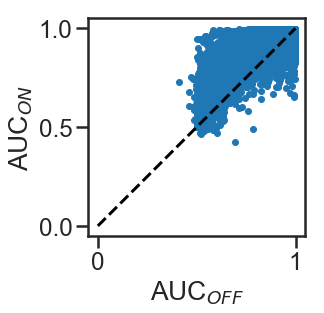

In [56]:
plt.plot(auc_off, auc_on, '.')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('AUC$_{OFF}$')
plt.ylabel('AUC$_{ON}$')
plt.axis('scaled');

In [57]:
import scipy
#np.sum(np.isnan(auc_on))
ind = np.isnan(auc_on)
scipy.stats.ttest_rel(auc_off[~ind], auc_on[~ind])

Ttest_relResult(statistic=-48.07010454927777, pvalue=0.0)

In [58]:
tprs_off = np.array(tprs_off)
tprs_on = np.array(tprs_on)
mean_tprs_off = np.nanmean(tprs_off, axis=0)
mean_tprs_on = np.nanmean(tprs_on, axis=0)
std_off = np.nanstd(tprs_off, axis=0)
std_on = np.nanstd(tprs_on, axis=0)

tprs_upper_off = np.minimum(mean_tprs_off + std_off, 1)
tprs_lower_off = mean_tprs_off - std_off
tprs_upper_on = np.minimum(mean_tprs_on + std_on, 1)
tprs_lower_on = mean_tprs_on - std_on


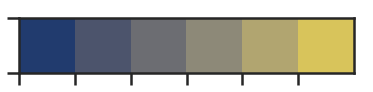

['#213b6e', '#4c556c', '#6c6e72', '#8e8978', '#b1a570', '#d9c55c']


In [59]:
pal_cyan = sns.color_palette("cividis", n_colors=6) #RdBu_r
sns.palplot(pal_cyan)
plt.show()
print(pal_cyan.as_hex())

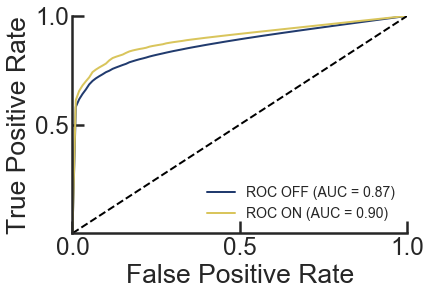

In [60]:

ax=plt.figure()

plt.plot(base_fpr, mean_tprs_off, color=pal_cyan[0], lw=2, label='ROC OFF (AUC = {0:0.2f})'''.format(np.mean(auc_off[~ind])))

plt.plot(base_fpr, mean_tprs_on, color=pal_cyan[-1], lw=2, label='ROC ON (AUC = {0:0.2f})'''.format(np.mean(auc_on[~ind])))

#plt.fill_between(base_fpr, tprs_lower_off, tprs_upper_off, color='grey', alpha=0.3)
#plt.fill_between(base_fpr, tprs_lower_on, tprs_upper_on, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0., 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1.])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('')
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.legend(fontsize=14, frameon=False)
plt.show()


In [77]:
### Plot some neurons Tuning Curve 

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


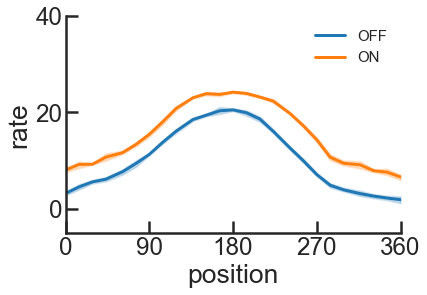

In [78]:
lables_=['OFF', 'ON']

for idx_I0E, I0E in enumerate([0, 0.5]):
    ########################################### OFF ############################################
    ## each column is a neuron
    nx_rates = Rates[:, 8011] #10000
    nx_positions = Positions
    ## get the ones according to the Iext you want
    nx_rates=nx_rates[IExts==I0E]
    nx_positions=nx_positions[IExts==I0E]
    dfx = pd.DataFrame({'position':nx_positions, 'rate':nx_rates, 'Neuron':Neuron})
    sns.lineplot('position', 'rate', data=dfx, label=lables_[idx_I0E])

plt.legend(loc=1, fontsize=15, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.ylim(-5,40)
plt.xlim(0,360)
plt.xticks([0,90,180,270,360]);
#
plt.show()

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


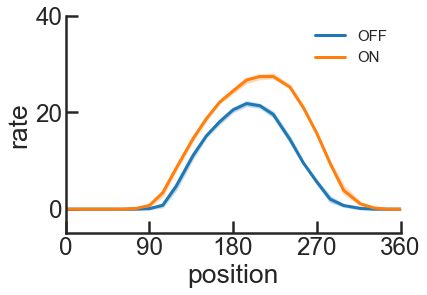

In [79]:
lables_=['OFF', 'ON']

for idx_I0E, I0E in enumerate([0, 0.5]):
    ########################################### OFF ############################################
    ## each column is a neuron
    nx_rates = Rates[:, 8001] #8001
    nx_positions = Positions
    ## get the ones according to the Iext you want
    nx_rates=nx_rates[IExts==I0E]
    nx_positions=nx_positions[IExts==I0E]
    dfx = pd.DataFrame({'position':nx_positions, 'rate':nx_rates, 'Neuron':Neuron})
    sns.lineplot('position', 'rate', data=dfx, label=lables_[idx_I0E])

plt.legend(loc=1, fontsize=15, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.ylim(-5,40)
plt.xlim(0,360)
plt.xticks([0,90,180,270,360]);
#
plt.show()

In [68]:
##center all the neurons to 180

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


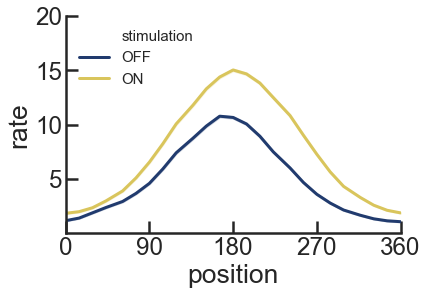

In [38]:
lables_=['OFF', 'ON']
frames=[]

for p in np.arange(0,16000,1): ##16000
    for idx_I0E, I0E in enumerate([0, 0.5]):
        ########################################### OFF ############################################
        ## each column is a neuron
        nx_rates = Rates[:, p] #rate during the delay period
        nx_positions = Positions
        ## get the ones according to the Iext you want
        nx_rates=nx_rates[IExts==I0E]
        nx_positions=nx_positions[IExts==I0E]
        ##normalize firing
        #if nx_rates.std() == 0:
        #    nx_rates = nx_rates-nx_rates.mean() 
        #else:
        #    nx_rates = (nx_rates-nx_rates.mean() )/nx_rates.std()        
        ##### alignment
        to_roll = np.where(nx_rates == max(nx_rates))[0][0] 
        rolled_rates = np.roll(nx_rates, -to_roll + int(len(nx_positions)/2) ) ### 63 is the m
        ###
        #dfx = pd.DataFrame({'position':nx_positions, 'rate':nx_rates, 'Neuron':Neuron, 'I0E':I0E})
        dfx = pd.DataFrame({'position':nx_positions, 'rate':rolled_rates, 'Neuron':Neuron, 'stimulation':lables_[idx_I0E]})
        frames.append(dfx)

###
### plot

dff = pd.concat(frames)
#dff.head()

ax=plt.figure()
sns.lineplot('position', 'rate', hue='stimulation', data=dff, palette=[pal_cyan.as_hex()[0], pal_cyan.as_hex()[-1]])
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.legend(fontsize=15, frameon=False)
plt.xlim(0,360)
plt.xticks([0,90,180,270,360]);
plt.ylim(0,20)
plt.yticks([5,10,15,20]);
##ax.savefig('C:\\Users\\David\\Desktop\\rates_Hansel.svg', transparent=True)

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


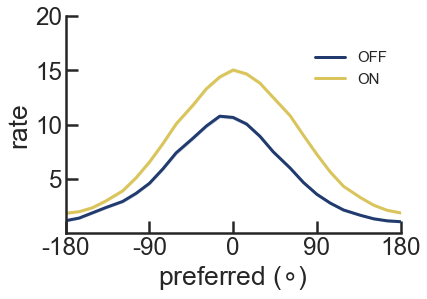

In [39]:
dff[' '] = dff['stimulation'].copy()

ax=plt.figure()
sns.lineplot('position', 'rate', hue=' ', data=dff, palette=[pal_cyan.as_hex()[0], pal_cyan.as_hex()[-1]])
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.legend(fontsize=15, frameon=False)
plt.xlim(0,360)
plt.xticks([0,90,180,270,360], ['-180', '-90', '0', '90', '180']);
plt.ylim(0,20)
plt.yticks([5,10,15,20]);
plt.xlabel((r'preferred ($\circ$)'));
ax.savefig('C:\\Users\\David\\Desktop\\tunings_Hansel.svg', transparent=True)

In [83]:
1500/(20*8)

9.375

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


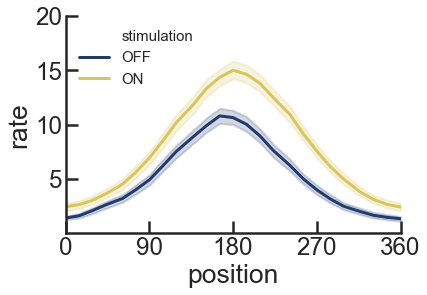

In [85]:
dff = pd.concat(frames)
#dff.head()

ax=plt.figure()
sns.lineplot('position', 'rate', hue='stimulation', data=dff, palette=[pal_cyan.as_hex()[0], pal_cyan.as_hex()[-1]])
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.legend(fontsize=15, frameon=False)
plt.xlim(0,360)
plt.xticks([0,90,180,270,360]);
plt.ylim(0,20)
plt.yticks([5,10,15,20]);
##ax.savefig('C:\\Users\\David\\Desktop\\rates_Hansel.svg', transparent=True)

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


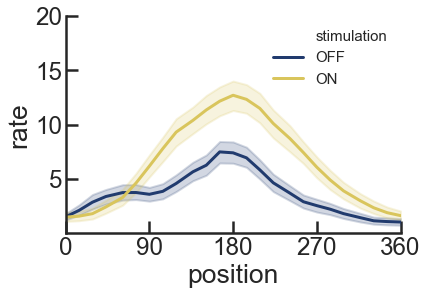

In [48]:
lables_=['OFF', 'ON']
frames=[]

for p in range(16000): ##16000
    for idx_I0E, I0E in enumerate([0, 0.5]):
        ########################################### OFF ############################################
        ## each column is a neuron
        nx_rates = Rates[:, p] #10000
        nx_positions = Positions
        ## get the ones according to the Iext you want
        nx_rates=nx_rates[IExts==I0E]
        nx_positions=nx_positions[IExts==I0E]
        ##normalize firing
        #if nx_rates.std() == 0:
        #    nx_rates = nx_rates-nx_rates.mean() 
        #else:
        #    nx_rates = (nx_rates-nx_rates.mean() )/nx_rates.std()        
        ##### alignment
        to_roll = np.where(nx_rates == max(nx_rates))[0][0] 
        rolled_rates = np.roll(nx_rates, -to_roll + int(len(nx_positions)/2) ) ### 63 is the m
        ###
        #dfx = pd.DataFrame({'position':nx_positions, 'rate':nx_rates, 'Neuron':Neuron, 'I0E':I0E})
        dfx = pd.DataFrame({'position':nx_positions, 'rate':rolled_rates, 'Neuron':Neuron, 'stimulation':lables_[idx_I0E]})
        frames.append(dfx)

###
### plot

dff2 = pd.concat(frames)
#dff.head()

ax=plt.figure()
sns.lineplot('position', 'rate', hue='stimulation', data=dff2, palette=[pal_cyan.as_hex()[0], pal_cyan.as_hex()[-1]])
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.legend(fontsize=15, frameon=False)
plt.xlim(0,360)
plt.xticks([0,90,180,270,360]);
plt.ylim(0,20)
plt.yticks([5,10,15,20]);
##ax.savefig('C:\\Users\\David\\Desktop\\rates_Hansel.svg', transparent=True)

